In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

from pysolar.solar import *
import pytz
import shap
import pickle
import multiprocessing


# Perameters


In [2]:
cheap_node_id = '001e06305a6b'
node_id = '10004098'
gps_node_id = '001e0610c2e9'
dir_out = '../figures/'
dir_data = '../data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1)).astype(str)
for i in range(len(wavelengths)):
    wavelengths[i] = wavelengths[i] + 'nm'
wavelengths = list(wavelengths)

## Read Data

In [4]:
# if data has been preprocessed before, run this directly
fn_data = dir_data + node_id + '_'+ cheap_node_id +'.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')


## Prepare Data  For Training

In [5]:
print(df.columns[:41]) # the last is UV Index
print('Variable Numbers in cheap sensors: 41')
print('Sample Numbers: ',len(df))

Index(['cloudPecentage', 'allRed', 'allGreen', 'allBlue', 'skyRed', 'skyGreen',
       'skyBlue', 'cloudRed', 'cloudGreen', 'cloudBlue', 'Violet', 'Blue',
       'Green', 'Yellow', 'Orange', 'Red', 'Temperature', 'Pressure',
       'Humidity', 'Latitude', 'Longitude', 'Altitude', 'NH3', 'CO', 'NO2',
       'C3H8', 'C4H10', 'CH4', 'H2', 'C2H5OH', 'c02', 'Luminosity', 'IR',
       'Full', 'Visible', 'Lux', 'UVA', 'UVB', 'Visible Compensation',
       'IR Compensation', 'UV Index'],
      dtype='object')
Variable Numbers in cheap sensors: 41
Sample Numbers:  144918


# Model Start from here

## Model for Single Wavelength Prediction

In [60]:
target = '600nm' 
target_name = target # this is for display
features = np.append(df.columns[:41], ['Zenith'])
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [61]:
RANDOM_STATE = 42
n_jobs = multiprocessing.cpu_count()

In [66]:
start_time = time.time()

# Random Forest Model, grid search to find best parameter
rfr = RandomForestRegressor(random_state = RANDOM_STATE, oob_score=True, n_jobs = n_jobs)
param_grid = {'max_depth': [10,20,30,40,50],'n_estimators': [30,40,50,60,80,100]}
CV_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid, cv =5, verbose = 3)

length_sample = len(X_train)//10
CV_rfr.fit(X_train[:length_sample], y_train[:length_sample])
print(CV_rfr.best_params_)
print(CV_rfr.best_score_)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] max_depth=10, n_estimators=30 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... max_depth=10, n_estimators=30, score=0.960, total=   2.0s
[CV] max_depth=10, n_estimators=30 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] ....... max_depth=10, n_estimators=30, score=0.961, total=   0.9s
[CV] max_depth=10, n_estimators=30 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] ....... max_depth=10, n_estimators=30, score=0.951, total=   0.8s
[CV] max_depth=10, n_estimators=30 ...................................
[CV] ....... max_depth=10, n_estimators=30, score=0.946, total=   0.8s
[CV] max_depth=10, n_estimators=30 ...................................
[CV] ....... max_depth=10, n_estimators=30, score=0.957, total=   0.8s
[CV] max_depth=10, n_estimators=40 ...................................
[CV] ....... max_depth=10, n_estimators=40, score=0.959, total=   1.0s
[CV] max_depth=10, n_estimators=40 ...................................
[CV] ....... max_depth=10, n_estimators=40, score=0.962, total=   1.1s
[CV] max_depth=10, n_estimators=40 ...................................
[CV] ....... max_depth=10, n_estimators=40, score=0.950, total=   1.0s
[CV] max_depth=10, n_estimators=40 ...................................
[CV] ....... max_depth=10, n_estimators=40, score=0.947, total=   1.1s
[CV] max_depth=10, n_estimators=40 ...................................
[CV] .

[CV] ....... max_depth=30, n_estimators=30, score=0.960, total=   1.0s
[CV] max_depth=30, n_estimators=30 ...................................
[CV] ....... max_depth=30, n_estimators=30, score=0.966, total=   1.0s
[CV] max_depth=30, n_estimators=30 ...................................
[CV] ....... max_depth=30, n_estimators=30, score=0.953, total=   1.0s
[CV] max_depth=30, n_estimators=30 ...................................
[CV] ....... max_depth=30, n_estimators=30, score=0.949, total=   1.0s
[CV] max_depth=30, n_estimators=30 ...................................
[CV] ....... max_depth=30, n_estimators=30, score=0.957, total=   1.0s
[CV] max_depth=30, n_estimators=40 ...................................
[CV] ....... max_depth=30, n_estimators=40, score=0.960, total=   1.3s
[CV] max_depth=30, n_estimators=40 ...................................
[CV] ....... max_depth=30, n_estimators=40, score=0.966, total=   1.4s
[CV] max_depth=30, n_estimators=40 ...................................
[CV] .

[CV] ...... max_depth=40, n_estimators=100, score=0.951, total=   3.9s
[CV] max_depth=40, n_estimators=100 ..................................
[CV] ...... max_depth=40, n_estimators=100, score=0.956, total=   3.9s
[CV] max_depth=50, n_estimators=30 ...................................
[CV] ....... max_depth=50, n_estimators=30, score=0.960, total=   1.3s
[CV] max_depth=50, n_estimators=30 ...................................
[CV] ....... max_depth=50, n_estimators=30, score=0.966, total=   1.2s
[CV] max_depth=50, n_estimators=30 ...................................
[CV] ....... max_depth=50, n_estimators=30, score=0.953, total=   1.3s
[CV] max_depth=50, n_estimators=30 ...................................
[CV] ....... max_depth=50, n_estimators=30, score=0.949, total=   1.2s
[CV] max_depth=50, n_estimators=30 ...................................
[CV] ....... max_depth=50, n_estimators=30, score=0.957, total=   1.1s
[CV] max_depth=50, n_estimators=40 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  5.0min finished


{'max_depth': 30, 'n_estimators': 100}
0.9587100181504213
--- 304.5483899116516 seconds ---


In [67]:
max_depth = 30 #CV_rfr.best_params_['max_depth'], # 30
n_estimators = 100 #CV_rfr.best_params_['n_estimators'])#100

regr = RandomForestRegressor(random_state = RANDOM_STATE,
                             max_depth=max_depth,
                             n_estimators=n_estimators,
                             n_jobs = n_jobs)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=8, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [68]:
fn_model = '../models/RF_'+target+'_dep'+str(max_depth)+'_ne'+str(n_estimators)+'.sav'
pickle.dump(regr, open(fn_model, 'wb'))


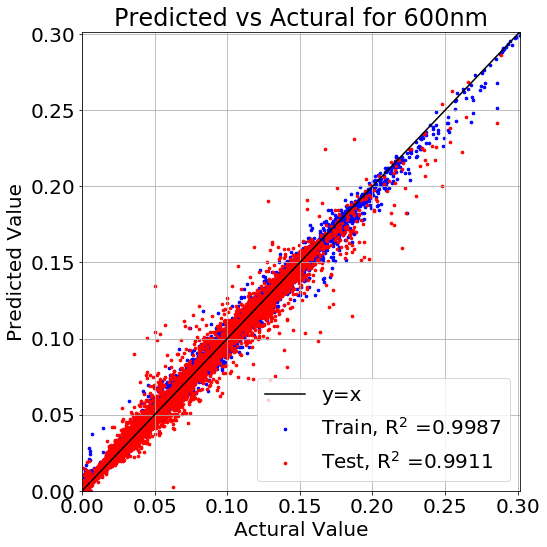

In [69]:
from sklearn.metrics import r2_score
train_score = r2_score(y_train,regr.predict(X_train))
test_score = r2_score(y_test,regr.predict(X_test))
    
y_line = np.linspace(np.min(y),np.max(y),100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')
plt.scatter(y_train,regr.predict(X_train), s=7, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
plt.scatter(y_test,regr.predict(X_test), s=7, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim((np.min(y),np.max(y)))
plt.ylim((np.min(y),np.max(y)))
ax.set_title('Predicted vs Actural for ' + target_name)
ax.set_xlabel('Actural Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()

if not os.path.exists(dir_out + target_name):
    os.mkdir(dir_out + target_name)
plt.savefig(dir_out + target_name +'/performance_'+target_name+'.png')


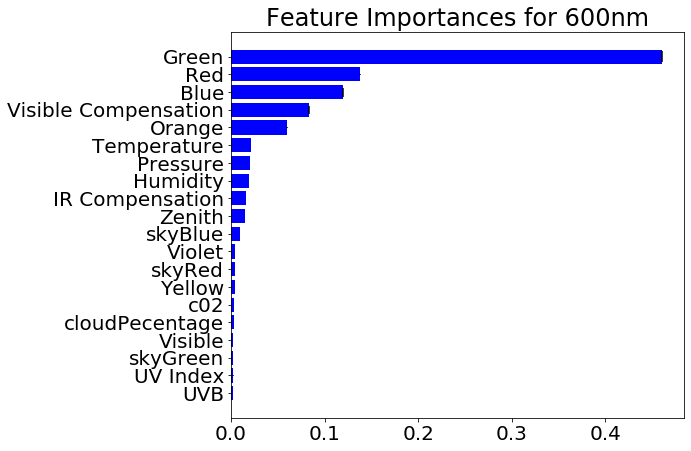

In [70]:
# rank feature inportance
num_features = 20
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

var_sorted = features[indices]
var_imp_sorted = importances[indices]

plt.rcParams["figure.figsize"] = (10, num_features/3) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
ax.barh(var_sorted[:num_features], var_imp_sorted[:num_features],
        yerr=std[indices][:num_features], ecolor='black',
        color = 'blue', align="center")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Feature Importances for ' + target_name)
plt.tight_layout()
plt.savefig(dir_out + target_name + '/feature_imp_'+ target_name+'.png')

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(regr)
# Calculate shap_values
num_shap = 500
shap_values = explainer.shap_values(X_train[:num_shap])

In [ ]:
# plot
shap.summary_plot(shap_values, X_train[:num_shap],
                  plot_size=(10,8),#'auto'
                  max_display = 20,
                  show=False
                 )
plt.tight_layout()
plt.savefig(dir_out + target_name + '/shap_'+ target_name+'.png')

cols = df.columns
size = len(cols)*0.8
fig = plt.figure(figsize=(size, size))
ax = fig.add_subplot(111)
cax = ax.matshow(df[cols].corr(), cmap='RdBu_r')
cax.set_clim(-1, 1);
#plt.title('Correlation Matrix\n\n\n')
fig.colorbar(cax)
ax.set_xticklabels([""]+cols, rotation=45, ha="left")
ax.set_yticklabels([""]+cols)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()